<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-05/AEs_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Variational Autoencoder and Generative Adversarial Network

For this task, I have chosen a different image dataset composed of street view images. Generating street view images will likely be a much more difficult task than generating numbers as in the MNIST dataset. Link to dataset: https://www.kaggle.com/datasets/paulchambaz/google-street-view. Below is visualization of a few random images from the dataset.

Mounted at /content/drive


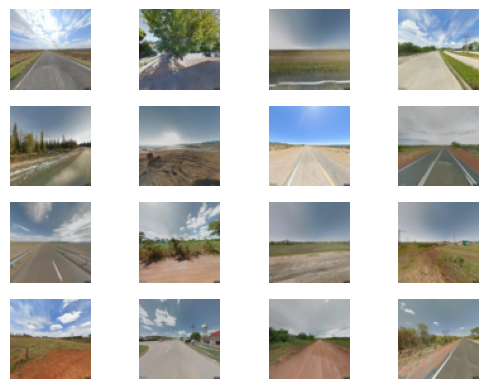

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from google.colab import drive
import torch

drive.mount('/content/drive')

im_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)),torchvision.transforms.ToTensor()])

train_im = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Street_View_Images', transform = im_transform)
train_loader = torch.utils.data.DataLoader(train_im, batch_size = 32, shuffle = True)
for i, (x, _) in enumerate(train_loader):
  if i == 16: break
  plt.subplot(4, 4, i+1)
  x = x.permute((0,2,3,1))
  plt.imshow(x[0, :, :, :])
  plt.axis('off')

Below is my implementation for a CVAE, as demonstrated in https://www.tensorflow.org/tutorials/generative/cvae. Since I am dealing with color images, the input and output channels are 3 instead of one.

In [3]:
import torch.nn as nn

class CVAE(nn.Module):
  def __init__(self, latent_dim, input_dim = (28, 28)):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * (input_dim[0] * input_dim[1])//16, latent_dim*2)
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 16*16*32),
        nn.ReLU(),
        nn.Unflatten(1, (32, 16, 16)),
        nn.ConvTranspose2d(32, 64, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1, bias = False),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1, bias = False),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 3, kernel_size = (3,3), stride = 1, padding = 1, bias = False)

    )


  def sample(self, eps = None):
    if eps is None:
      eps = torch.randn([2000, self.latent_dim])
    return self.decode(eps, apply_sigmoid = True)

  def encode(self, x):
    mean, logvar = torch.split(self.encoder(x), self.latent_dim, dim=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = torch.randn(mean.shape)
    return eps * torch.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid = False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = torch.sigmoid(logits)
      return probs
    return logits

Below I train and test my CVAE implementation. I used a much larger amount of latent dimensions in hopes of capturing more complex representations.

100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


3.388710385277158


100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


0.6913806029728481


100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


0.6889229331697736


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


0.6853120497294835


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


0.6816751644724891


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


0.676967183748881


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


0.6799512846129281


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


0.6805680961835952


100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


0.6752337983676365


100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


0.671914259592692


100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


0.6734422274998256


100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


0.6676365279016041


100%|██████████| 21/21 [00:13<00:00,  1.51it/s]


0.6731665787242708


100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


0.6731559918040321


100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


0.6701636144093105


100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


0.6671250717980521


100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


0.6719635384423392


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


0.6725828590847197


100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


0.6726022135643732


100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


0.6872881111644563


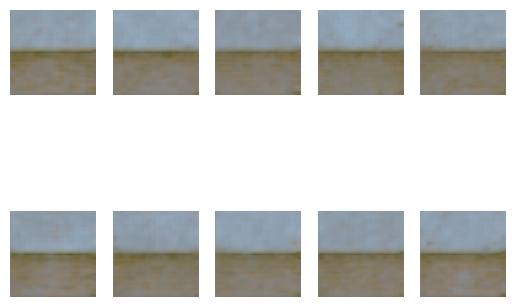

In [58]:
from torch import optim
from tqdm import tqdm

bce_loss = nn.BCEWithLogitsLoss()

def log_norm_pdf(sample, mean, logvar, raxis = 1):
  if type(logvar) is float:
    return torch.sum(-0.5*((sample-mean)**2*np.exp(-logvar)+logvar+np.log(2*np.pi)), dim=raxis)
  else:
    return torch.sum(-0.5*((sample-mean)**2*torch.exp(-logvar)+logvar+np.log(2*np.pi)), dim=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  xlogit = model.decode(z)
  logpx_z = -bce_loss(xlogit, x)
  logpz = log_norm_pdf(z, 0., 0.)
  logqz_x = log_norm_pdf(z, mean, logvar)
  return -torch.mean(logpx_z + logpz - logqz_x)

latent_size = 100
model = CVAE(latent_size, (64, 64))
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 20


for e in range(epochs):
  model.train()
  losses = []
  for i, (train_im, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
    optimizer.zero_grad()
    loss = compute_loss(model, train_im)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  print(np.mean(losses))


with torch.no_grad():
  # c = torch.eye(10, 10)
  sample = model.sample()
  sample = sample.permute(0,2,3,1)
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(sample[i,:,:,:]*255, dtype=np.uint8))
    plt.axis('off')
  plt.show()

Although these results aren't perfect, I at least believe my implementation to be mostly correct. There is a clear horizon line and the colors are more or less as expected for a google street view image.

Below are my implementations for a generator and discriminator, consistent with https://www.tensorflow.org/tutorials/generative/dcgan. I added more convolution layers to the discriminator, and decreased the dimensionality of the convolution layers. In earlier iterations of my model, I found that the discriminator was not learning as well as I wanted, which led to the addition of another layer in hopes of better distinction between real and fake images.

In [4]:



class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1000, 64*16*16, bias=False),
        nn.Unflatten(1, (64, 16, 16)),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size = (5,5), stride = 1, padding = 2, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size = (5,5), stride = 2, padding = 2, output_padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

class Discriminator(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(8, 16, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(16, 32, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(32, 64, kernel_size = (5, 5), stride = 2, padding = 2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.Linear((input_size*input_size)//512*128, 1)

    )

  def forward(self, x):
    return self.layers(x)



Below, I train and test my GAN.

100%|██████████| 21/21 [00:09<00:00,  2.15it/s]

Epoch 0 | Generator loss: 2.482781 | Discriminator loss: 0.648340


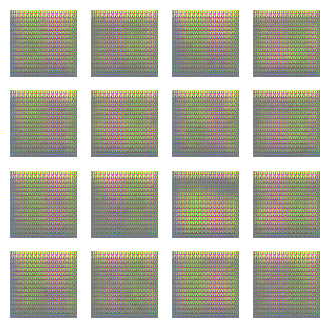

100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 1 | Generator loss: 5.035279 | Discriminator loss: 1.090408


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 2 | Generator loss: 7.560981 | Discriminator loss: 0.433604


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 3 | Generator loss: 6.420720 | Discriminator loss: 0.322966


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 4 | Generator loss: 8.674405 | Discriminator loss: 0.596356


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 5 | Generator loss: 6.568017 | Discriminator loss: 0.550339


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 6 | Generator loss: 5.115239 | Discriminator loss: 0.101519


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Epoch 7 | Generator loss: 5.084076 | Discriminator loss: 0.263024


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 8 | Generator loss: 8.989727 | Discriminator loss: 0.144876


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 9 | Generator loss: 5.743921 | Discriminator loss: 0.424291


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]

Epoch 10 | Generator loss: 3.644071 | Discriminator loss: 0.527767


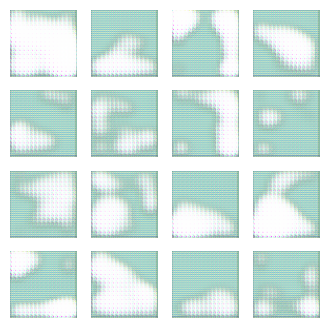

100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 11 | Generator loss: 3.927098 | Discriminator loss: 0.498560


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 12 | Generator loss: 3.337144 | Discriminator loss: 0.394932


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 13 | Generator loss: 2.773401 | Discriminator loss: 0.438207


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 14 | Generator loss: 1.886878 | Discriminator loss: 0.647829


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 15 | Generator loss: 4.496575 | Discriminator loss: 0.418736


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 16 | Generator loss: 2.999134 | Discriminator loss: 0.361749


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 17 | Generator loss: 6.381238 | Discriminator loss: 0.658347


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 18 | Generator loss: 1.656312 | Discriminator loss: 0.998064


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 19 | Generator loss: 3.805229 | Discriminator loss: 0.779063


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]

Epoch 20 | Generator loss: 1.645566 | Discriminator loss: 1.005254


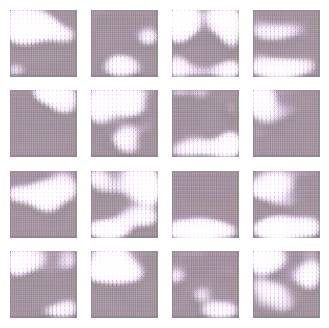

100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 21 | Generator loss: 1.144530 | Discriminator loss: 0.901262


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 22 | Generator loss: 1.559302 | Discriminator loss: 0.808749


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch 23 | Generator loss: 2.162930 | Discriminator loss: 0.538739


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 24 | Generator loss: 1.148134 | Discriminator loss: 1.101472


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 25 | Generator loss: 1.030479 | Discriminator loss: 1.173248


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 26 | Generator loss: 1.113891 | Discriminator loss: 1.119816


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 27 | Generator loss: 1.040931 | Discriminator loss: 1.218458


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch 28 | Generator loss: 1.363980 | Discriminator loss: 0.895155


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 29 | Generator loss: 1.436503 | Discriminator loss: 1.097736


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 30 | Generator loss: 1.502822 | Discriminator loss: 1.300501


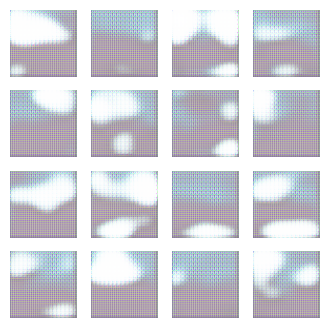

100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 31 | Generator loss: 0.810994 | Discriminator loss: 1.369065


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 32 | Generator loss: 1.220124 | Discriminator loss: 1.041754


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 33 | Generator loss: 2.526910 | Discriminator loss: 0.584323


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 34 | Generator loss: 2.241582 | Discriminator loss: 1.789050


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 35 | Generator loss: 3.200551 | Discriminator loss: 0.778377


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 36 | Generator loss: 2.397214 | Discriminator loss: 1.110173


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 37 | Generator loss: 4.019045 | Discriminator loss: 0.475428


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 38 | Generator loss: 6.831338 | Discriminator loss: 0.702671


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 39 | Generator loss: 2.694633 | Discriminator loss: 0.869054


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]

Epoch 40 | Generator loss: 4.264623 | Discriminator loss: 0.667809


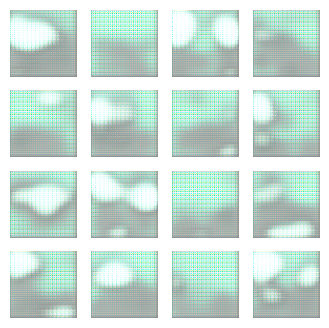

100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 41 | Generator loss: 4.032792 | Discriminator loss: 0.370864


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Epoch 42 | Generator loss: 2.329408 | Discriminator loss: 0.971172


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 43 | Generator loss: 3.104943 | Discriminator loss: 0.429380


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 44 | Generator loss: 1.687525 | Discriminator loss: 1.772295


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 45 | Generator loss: 0.721987 | Discriminator loss: 1.384026


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Epoch 46 | Generator loss: 1.145296 | Discriminator loss: 1.002697


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 47 | Generator loss: 2.260815 | Discriminator loss: 0.525778


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 48 | Generator loss: 1.363496 | Discriminator loss: 0.789776


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 49 | Generator loss: 1.997622 | Discriminator loss: 0.379941


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]

Epoch 50 | Generator loss: 2.677595 | Discriminator loss: 0.406878


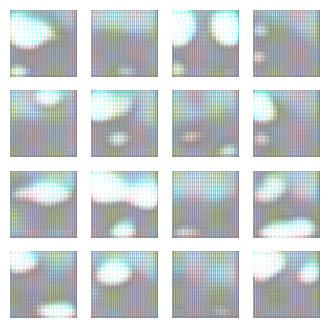

100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch 51 | Generator loss: 3.286824 | Discriminator loss: 0.560478


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 52 | Generator loss: 4.748537 | Discriminator loss: 0.891304


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Epoch 53 | Generator loss: 2.623602 | Discriminator loss: 0.835101


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 54 | Generator loss: 3.345398 | Discriminator loss: 0.475852


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 55 | Generator loss: 2.633824 | Discriminator loss: 0.500247


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 56 | Generator loss: 1.041866 | Discriminator loss: 2.084159


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 57 | Generator loss: 0.907604 | Discriminator loss: 1.376520


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Epoch 58 | Generator loss: 0.955738 | Discriminator loss: 1.236944


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 59 | Generator loss: 1.809259 | Discriminator loss: 0.759361


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]

Epoch 60 | Generator loss: 2.938987 | Discriminator loss: 0.399049


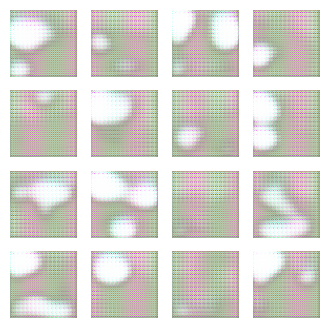

100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 61 | Generator loss: 1.756277 | Discriminator loss: 0.798666


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Epoch 62 | Generator loss: 4.318919 | Discriminator loss: 0.152047


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 63 | Generator loss: 2.830419 | Discriminator loss: 0.442350


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 64 | Generator loss: 5.691228 | Discriminator loss: 0.248416


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 65 | Generator loss: 3.243955 | Discriminator loss: 0.656996


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 66 | Generator loss: 4.959893 | Discriminator loss: 0.923007


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 67 | Generator loss: 1.534235 | Discriminator loss: 1.013883


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 68 | Generator loss: 2.073887 | Discriminator loss: 1.031213


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Epoch 69 | Generator loss: 1.535443 | Discriminator loss: 1.145095


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 70 | Generator loss: 2.955698 | Discriminator loss: 0.933692


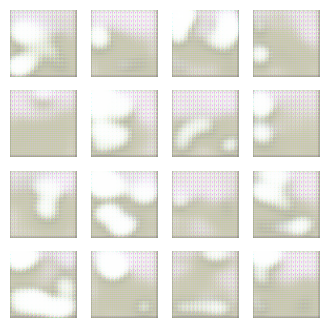

100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 71 | Generator loss: 2.077422 | Discriminator loss: 1.231489


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 72 | Generator loss: 1.963222 | Discriminator loss: 1.227960


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 73 | Generator loss: 2.159098 | Discriminator loss: 0.746993


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 74 | Generator loss: 2.007208 | Discriminator loss: 1.353886


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 75 | Generator loss: 3.080645 | Discriminator loss: 0.536305


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 76 | Generator loss: 4.274110 | Discriminator loss: 0.787200


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 77 | Generator loss: 3.129247 | Discriminator loss: 0.853381


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 78 | Generator loss: 4.188111 | Discriminator loss: 0.212219


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch 79 | Generator loss: 3.196362 | Discriminator loss: 0.306660


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 80 | Generator loss: 3.598505 | Discriminator loss: 0.706974


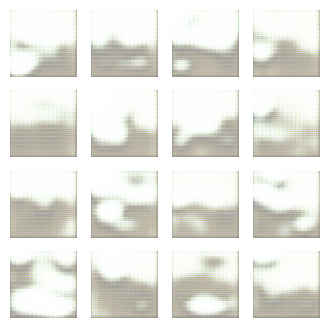

100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 81 | Generator loss: 2.139484 | Discriminator loss: 0.619027


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 82 | Generator loss: 2.079545 | Discriminator loss: 1.220046


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 83 | Generator loss: 2.009164 | Discriminator loss: 0.994006


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 84 | Generator loss: 2.778604 | Discriminator loss: 0.437032


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch 85 | Generator loss: 2.209892 | Discriminator loss: 1.263355


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 86 | Generator loss: 2.615888 | Discriminator loss: 0.309435


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 87 | Generator loss: 3.222258 | Discriminator loss: 0.495583


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 88 | Generator loss: 3.397102 | Discriminator loss: 1.579058


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 89 | Generator loss: 2.853620 | Discriminator loss: 0.785537


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]

Epoch 90 | Generator loss: 1.589785 | Discriminator loss: 1.534674


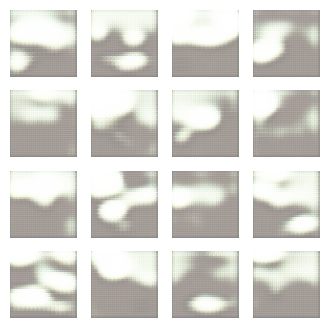

100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 91 | Generator loss: 0.939486 | Discriminator loss: 1.197172


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 92 | Generator loss: 1.456637 | Discriminator loss: 0.832096


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 93 | Generator loss: 1.566812 | Discriminator loss: 0.723827


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 94 | Generator loss: 2.233637 | Discriminator loss: 0.776193


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 95 | Generator loss: 2.507108 | Discriminator loss: 1.286293


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 96 | Generator loss: 1.610989 | Discriminator loss: 1.153498


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Epoch 97 | Generator loss: 3.233732 | Discriminator loss: 0.552021


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 98 | Generator loss: 4.067820 | Discriminator loss: 1.027667


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 99 | Generator loss: 1.243350 | Discriminator loss: 1.875799


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]

Epoch 100 | Generator loss: 1.376987 | Discriminator loss: 0.927073


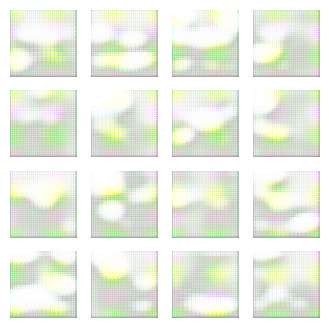

100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 101 | Generator loss: 3.048632 | Discriminator loss: 0.300586


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 102 | Generator loss: 4.514221 | Discriminator loss: 0.299812


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


Epoch 103 | Generator loss: 2.247785 | Discriminator loss: 1.717324


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 104 | Generator loss: 1.214451 | Discriminator loss: 1.120346


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 105 | Generator loss: 2.615171 | Discriminator loss: 0.460983


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 106 | Generator loss: 2.381447 | Discriminator loss: 0.848312


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 107 | Generator loss: 1.142954 | Discriminator loss: 1.037167


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 108 | Generator loss: 1.488171 | Discriminator loss: 0.859744


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 109 | Generator loss: 1.487959 | Discriminator loss: 1.391414


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 110 | Generator loss: 1.180837 | Discriminator loss: 1.008947


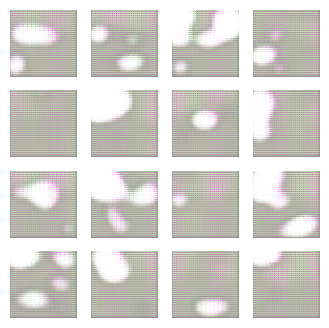

100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 111 | Generator loss: 1.140023 | Discriminator loss: 0.932583


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 112 | Generator loss: 1.897190 | Discriminator loss: 0.500561


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 113 | Generator loss: 2.515188 | Discriminator loss: 0.559864


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 114 | Generator loss: 3.370496 | Discriminator loss: 0.330206


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 115 | Generator loss: 2.884493 | Discriminator loss: 0.265992


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 116 | Generator loss: 4.132514 | Discriminator loss: 0.128322


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 117 | Generator loss: 4.601815 | Discriminator loss: 0.109759


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 118 | Generator loss: 4.289272 | Discriminator loss: 0.417501


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 119 | Generator loss: 2.404371 | Discriminator loss: 1.223598


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 120 | Generator loss: 3.095152 | Discriminator loss: 0.396447


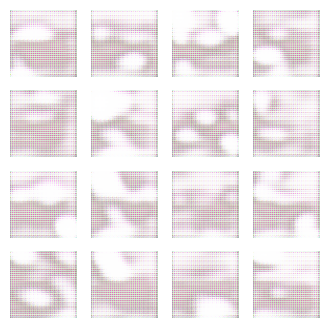

100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Epoch 121 | Generator loss: 3.490162 | Discriminator loss: 1.022873


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 122 | Generator loss: 1.963861 | Discriminator loss: 0.675354


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 123 | Generator loss: 3.219981 | Discriminator loss: 0.239906


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 124 | Generator loss: 2.234462 | Discriminator loss: 1.514371


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 125 | Generator loss: 1.536566 | Discriminator loss: 0.965110


100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Epoch 126 | Generator loss: 1.996397 | Discriminator loss: 0.586010


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 127 | Generator loss: 1.686835 | Discriminator loss: 1.185169


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 128 | Generator loss: 2.551517 | Discriminator loss: 0.756478


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 129 | Generator loss: 3.202795 | Discriminator loss: 0.785204


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]

Epoch 130 | Generator loss: 3.068748 | Discriminator loss: 0.854466


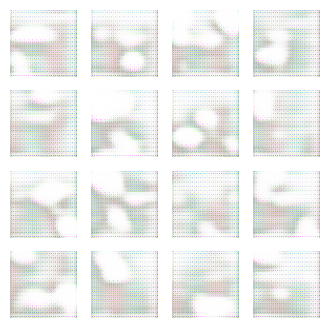

100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Epoch 131 | Generator loss: 2.471645 | Discriminator loss: 0.880322


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Epoch 132 | Generator loss: 2.522900 | Discriminator loss: 0.673741


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 133 | Generator loss: 4.212169 | Discriminator loss: 0.176434


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 134 | Generator loss: 2.366294 | Discriminator loss: 1.367568


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 135 | Generator loss: 3.180218 | Discriminator loss: 0.367741


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Epoch 136 | Generator loss: 4.297330 | Discriminator loss: 0.743507


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Epoch 137 | Generator loss: 3.119697 | Discriminator loss: 0.636348


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 138 | Generator loss: 4.682329 | Discriminator loss: 0.247828


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 139 | Generator loss: 4.281360 | Discriminator loss: 1.320304


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 140 | Generator loss: 2.697391 | Discriminator loss: 1.666843


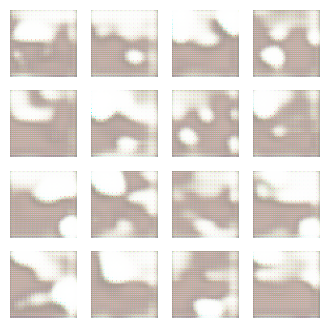

100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 141 | Generator loss: 2.106766 | Discriminator loss: 0.722703


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 142 | Generator loss: 1.673057 | Discriminator loss: 0.803555


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 143 | Generator loss: 1.537159 | Discriminator loss: 0.899149


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 144 | Generator loss: 1.884035 | Discriminator loss: 0.846369


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 145 | Generator loss: 1.194515 | Discriminator loss: 1.202221


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 146 | Generator loss: 1.361457 | Discriminator loss: 0.953352


100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Epoch 147 | Generator loss: 1.851326 | Discriminator loss: 0.621294


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 148 | Generator loss: 2.214807 | Discriminator loss: 0.571344


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 149 | Generator loss: 1.707646 | Discriminator loss: 1.010091


100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Epoch 150 | Generator loss: 1.622527 | Discriminator loss: 1.055801


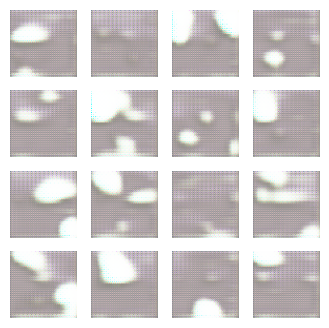

100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 151 | Generator loss: 1.780980 | Discriminator loss: 1.058395


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 152 | Generator loss: 1.738933 | Discriminator loss: 1.195302


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 153 | Generator loss: 1.375068 | Discriminator loss: 1.182395


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 154 | Generator loss: 1.187202 | Discriminator loss: 1.032257


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 155 | Generator loss: 1.260785 | Discriminator loss: 1.020209


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


Epoch 156 | Generator loss: 1.239344 | Discriminator loss: 1.112140


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 157 | Generator loss: 1.938154 | Discriminator loss: 0.632567


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 158 | Generator loss: 2.607405 | Discriminator loss: 0.642905


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 159 | Generator loss: 2.339853 | Discriminator loss: 0.802609


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 160 | Generator loss: 2.344977 | Discriminator loss: 0.658457


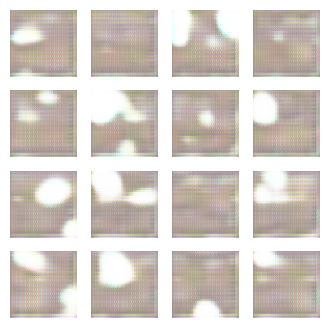

100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 161 | Generator loss: 2.836972 | Discriminator loss: 0.516443


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 162 | Generator loss: 4.081761 | Discriminator loss: 0.740482


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 163 | Generator loss: 1.548248 | Discriminator loss: 0.933027


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Epoch 164 | Generator loss: 2.074225 | Discriminator loss: 0.629389


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 165 | Generator loss: 2.483362 | Discriminator loss: 0.465409


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 166 | Generator loss: 2.587638 | Discriminator loss: 0.625730


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 167 | Generator loss: 2.378661 | Discriminator loss: 0.663784


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Epoch 168 | Generator loss: 2.793114 | Discriminator loss: 1.378675


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 169 | Generator loss: 4.276488 | Discriminator loss: 0.191725


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]

Epoch 170 | Generator loss: 2.363719 | Discriminator loss: 0.862175


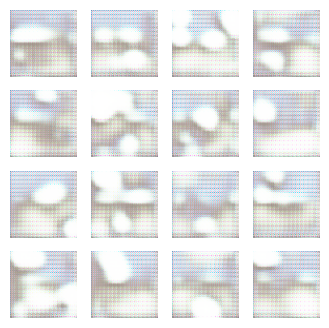

100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 171 | Generator loss: 3.893238 | Discriminator loss: 0.287262


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 172 | Generator loss: 2.864324 | Discriminator loss: 0.854413


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 173 | Generator loss: 3.175852 | Discriminator loss: 0.543591


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 174 | Generator loss: 3.103264 | Discriminator loss: 0.598101


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Epoch 175 | Generator loss: 2.940212 | Discriminator loss: 0.386379


100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


Epoch 176 | Generator loss: 3.443082 | Discriminator loss: 0.709017


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


Epoch 177 | Generator loss: 3.103876 | Discriminator loss: 0.776110


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 178 | Generator loss: 1.910151 | Discriminator loss: 0.820017


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 179 | Generator loss: 2.020843 | Discriminator loss: 0.599229


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 180 | Generator loss: 3.029689 | Discriminator loss: 0.574783


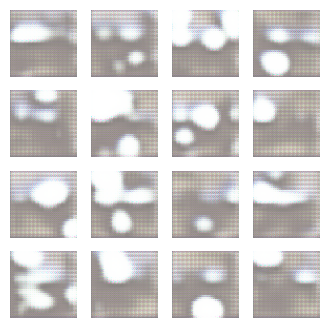

100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 181 | Generator loss: 3.371546 | Discriminator loss: 0.793400


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


Epoch 182 | Generator loss: 2.796806 | Discriminator loss: 0.541808


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 183 | Generator loss: 2.337706 | Discriminator loss: 0.669994


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 184 | Generator loss: 2.865632 | Discriminator loss: 0.526826


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Epoch 185 | Generator loss: 2.039679 | Discriminator loss: 1.023350


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 186 | Generator loss: 2.603385 | Discriminator loss: 0.702947


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 187 | Generator loss: 6.133290 | Discriminator loss: 0.692535


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 188 | Generator loss: 2.402639 | Discriminator loss: 0.558777


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 189 | Generator loss: 2.570271 | Discriminator loss: 0.519228


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 190 | Generator loss: 1.577386 | Discriminator loss: 1.179967


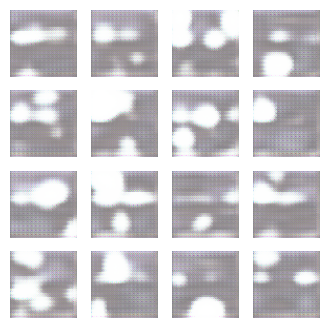

100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Epoch 191 | Generator loss: 1.518422 | Discriminator loss: 1.166979


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Epoch 192 | Generator loss: 2.376144 | Discriminator loss: 0.692105


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Epoch 193 | Generator loss: 2.048387 | Discriminator loss: 1.194607


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Epoch 194 | Generator loss: 1.951097 | Discriminator loss: 0.942971


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Epoch 195 | Generator loss: 1.366545 | Discriminator loss: 0.880637


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Epoch 196 | Generator loss: 1.777992 | Discriminator loss: 0.716954


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 197 | Generator loss: 1.755685 | Discriminator loss: 0.850773


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


Epoch 198 | Generator loss: 1.865324 | Discriminator loss: 0.886256


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]

Epoch 199 | Generator loss: 2.281462 | Discriminator loss: 0.681230


In [11]:
from torch import optim
from tqdm import tqdm


def gen_loss(output):
  return nn.BCEWithLogitsLoss()(output, torch.ones_like(output))

def disc_loss(real, fake):
  real_loss = nn.BCEWithLogitsLoss()(real, torch.ones_like(real))
  fake_loss = nn.BCEWithLogitsLoss()(fake, torch.zeros_like(fake))
  return real_loss + fake_loss

generator = Generator()
discriminator = Discriminator(64)
gen_opt = optim.Adam(generator.parameters(), lr = 0.001)
disc_opt = optim.Adam(discriminator.parameters(), lr = 0.001)
BATCH_SIZE = 32
noise_dim = 1000
epochs = 200
samples_to_gen = 16
test_noise = torch.randn([samples_to_gen, noise_dim])




for e in range(epochs):
  generator.train()
  discriminator.train()
  g_losses, d_losses = [], []
  for i, (train_im, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
    disc_opt.zero_grad()

    noise = torch.randn([BATCH_SIZE, noise_dim])
    generated_images = generator(noise)

    real_output = discriminator(train_im)
    fake_output = discriminator(generated_images.detach())

    disc_l = disc_loss(real_output, fake_output)
    disc_l.backward()
    disc_opt.step()

    gen_opt.zero_grad()
    fake_output = discriminator(generated_images)
    gen_l = gen_loss(fake_output)
    gen_l.backward()
    gen_opt.step()


    g_losses.append(gen_l.item())
    d_losses.append(disc_l.item())



  print("Epoch {} | Generator loss: {:.6f} | Discriminator loss: {:.6f}".format(e, np.mean(g_losses), np.mean(d_losses)))

  if e % 10 == 0:
    generator.eval()
    with torch.no_grad():
      predictions = generator(test_noise)
      predictions = predictions.permute(0,2,3,1)
      fig = plt.figure(figsize=(4, 4))

      for i in range(predictions.shape[0]):
          plt.subplot(4, 4, i+1)
          # print(predictions[i])
          plt.imshow(np.array(predictions[i, :, :, :]*127.5+127.5, dtype=np.uint8))
          plt.axis('off')
      plt.show()





These results don't look perfect, but clearly depict something that looks like a countryside (with more epochs, this becomes more obvious). I think these results are a lot less clear than the MNIST dataset due to the comparative complexity. Whereas the handwritten digits always have a perfectly black background and white subject, this is a whole landscape, from sometimes completely different places, taken from different angles and with certain artifacts, times of day, etc. Additionally, I am trying to generate images with 3 different color channels, which makes the dataset much more complex on top of it.